In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
zeos = ['MOR','RHO','MFI','ITW']

Text(0.5, 0, 'num of al subs')

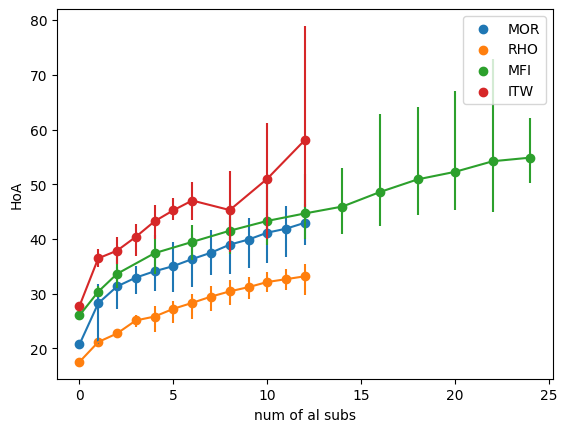

In [13]:
for zeo in zeos:
    atoms, hoa = np.load(f'data/{zeo}/atoms.npy'), np.load(f'data/{zeo}/hoa.npy')
    n_ats = atoms.sum(1)
    x = []
    y = []
    y_ci_min = []
    y_ci_max = []
    for i in np.unique(n_ats):
        _x = hoa[n_ats==i]
    
        x.append(i)
        y.append(np.mean(_x))
    
        b,t = np.quantile(_x, [0.05, 0.95])
        y_ci_min.append(b)
        y_ci_max.append(t)
    
    line = plt.plot(x,y)
    plt.scatter(x,y, c=line[0].get_color(), label=zeo)
    plt.vlines(x, y_ci_min, y_ci_max, colors=line[0].get_color())
plt.legend()
plt.ylabel('HoA')
plt.xlabel('num of al subs')